In [96]:
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns',30)
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import random
from sklearn.metrics import f1_score,roc_auc_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from rfpimp import *
from xgboost import XGBClassifier

In [97]:
with open('train_demo.pkl','rb') as f:
    df_train_demo = pickle.load(f)
with open('train_hist.pkl','rb') as f:
    df_train_hist = pickle.load(f)

In [98]:
with open('test_demo.pkl','rb') as f:
    df_test_demo = pickle.load(f)
with open('test_hist.pkl','rb') as f:
    df_test_hist = pickle.load(f)

In [99]:
df_train_demo.head(10)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months
5,9,Monthly,Arrear,Closed,Billed,5,RAIPUR,48,400000,280000.0,280000.0,53000.0,2011-12-19,2015-12-15,2011-12-19,3413012,1019,54689,70.00,M,40.0,42083.33,RAIPUR,CHATTISGARH,493885.0,No Top-up Service
6,10,Monthly,Arrear,Closed,PDC_E,5,RAIPUR,48,716000,450000.0,450000.0,2000.0,2011-12-31,2015-12-05,2011-12-31,3553579,1019,54689,62.85,M,23.0,46221.00,RAIPUR,CHATTISGARH,493889.0,No Top-up Service
7,11,Monthly,Arrear,Closed,PDC_E,5,RAIPUR,48,600000,360000.0,360000.0,11000.0,2012-02-09,2016-02-15,2012-02-09,4008234,1187,21232,60.00,M,41.0,46195.08,RAIPUR,CHATTISGARH,493114.0,No Top-up Service
8,12,Monthly,Arrear,Closed,PDC,5,RAIPUR,46,539275,400000.0,400000.0,50000.0,2012-03-29,2016-01-15,2012-03-29,4603217,1046,24760,74.17,M,51.0,15000.00,RAIPUR,CHATTISGARH,493196.0,No Top-up Service
9,13,Monthly,Arrear,Closed,PDC,5,RAIPUR,48,689275,490000.0,490000.0,10000.0,2012-03-30,2016-02-15,2012-03-30,4619836,1046,24760,71.09,M,33.0,31666.67,RAIPUR,CHATTISGARH,493344.0,No Top-up Service


<AxesSubplot:>

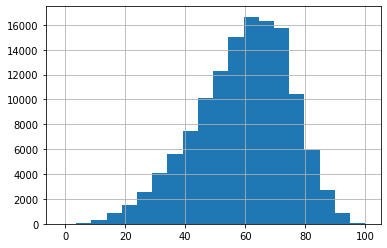

In [100]:
df_train_demo['LTV'].hist(bins=20)

In [101]:
df_train_demo[df_train_demo['LTV'] > 80]['Top-up Month'].value_counts(normalize=True)

No Top-up Service    0.777674
 > 48 Months         0.093124
36-48 Months         0.048261
30-36 Months         0.035961
24-30 Months         0.027527
18-24 Months         0.012651
12-18 Months         0.004803
Name: Top-up Month, dtype: float64

In [102]:
df_train_demo[df_train_demo['LoanStatus'] == 'Closed']['Top-up Month'].value_counts(normalize=True)

No Top-up Service    0.859799
 > 48 Months         0.079274
36-48 Months         0.021999
24-30 Months         0.011296
30-36 Months         0.010777
18-24 Months         0.010057
12-18 Months         0.006797
Name: Top-up Month, dtype: float64

In [103]:
df_train_demo.isnull().sum()

ID                     0
Frequency              0
InstlmentMode          0
LoanStatus             0
PaymentMode            0
BranchID               0
Area               11653
Tenure                 0
AssetCost              0
AmountFinance          0
DisbursalAmount        0
EMI                    0
DisbursalDate          0
MaturityDAte           1
AuthDate               0
AssetID                0
ManufacturerID         0
SupplierID             0
LTV                    0
SEX                   59
AGE                   59
MonthlyIncome        234
City               11256
State                  0
ZiPCODE              372
Top-up Month           0
dtype: int64

In [104]:
df_train_demo[df_train_demo['AmountFinance'] > df_train_demo['DisbursalAmount']]['Top-up Month'].value_counts(normalize=True)

No Top-up Service    0.800562
24-30 Months         0.053371
18-24 Months         0.042837
30-36 Months         0.039326
36-48 Months         0.026685
 > 48 Months         0.024579
12-18 Months         0.012640
Name: Top-up Month, dtype: float64

In [105]:
df_train_demo[df_train_demo['AmountFinance'] == df_train_demo['DisbursalAmount']]['Top-up Month'].value_counts(normalize=True)

No Top-up Service    0.829491
 > 48 Months         0.065479
36-48 Months         0.028436
24-30 Months         0.026849
30-36 Months         0.023626
18-24 Months         0.018132
12-18 Months         0.007985
Name: Top-up Month, dtype: float64

In [106]:
df_train_demo[df_train_demo['AuthDate'] < df_train_demo['DisbursalDate']]

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
174,182,Monthly,Advance,Closed,Billed,9,BURDWAN,35,487930,280000.0,280000.0,11500.0,2010-07-16,2013-05-15,2010-07-15,540087,1046,24390,55.03,M,40.0,15209.08,NaN,WEST BENGAL,712413.0,No Top-up Service
182,190,Monthly,Advance,Closed,Billed,9,BURDWAN,22,535848,200000.0,200000.0,20070.0,2010-09-30,2012-07-05,2010-09-29,644714,1019,22934,33.58,M,56.0,36349.33,NaN,WEST BENGAL,712302.0,No Top-up Service
190,198,Monthly,Advance,Closed,Billed,9,BURDWAN,22,468834,200000.0,200000.0,19800.0,2010-10-31,2012-08-05,2010-10-30,743423,1019,22934,38.44,M,25.0,12500.00,NaN,WEST BENGAL,713359.0,No Top-up Service
560,573,Quatrly,Arrear,Closed,PDC,22,JALANDHAR,36,445000,325000.0,325000.0,35820.0,2010-04-06,2013-03-20,2010-04-01,481066,1060,36011,64.98,M,42.0,36600.00,NaN,PUNJAB,144022.0,No Top-up Service
571,584,Monthly,Arrear,Closed,PDC,22,JALANDHAR,36,435000,325000.0,325000.0,12010.0,2010-11-11,2013-10-15,2010-11-10,784696,1046,23966,74.71,M,54.0,30000.00,NaN,PUNJAB,144005.0,No Top-up Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105583,118373,Monthly,Arrear,Closed,Direct Debit,143,NEW DELHI BARAKHAMBHA ROAD,12,500000,200000.0,200000.0,18294.0,2015-01-10,2016-01-10,2015-01-09,14747538,1019,93240,40.00,M,25.0,17916.67,REWARI,HARYANA,123401.0,No Top-up Service
109447,122543,Half Yearly,Arrear,Active,ECS,281,JAIPUR,36,600000,401612.0,401612.0,85100.0,2017-11-20,2020-11-05,2017-11-18,27317605,1019,50206,52.75,M,32.0,31250.00,JAIPUR,RAJASTHAN,303102.0,No Top-up Service
114931,128452,Half Yearly,Arrear,Active,ECS,148,NaN,48,700000,400000.0,400000.0,69000.0,2018-01-23,2021-12-10,2018-01-13,28040045,1062,87216,47.29,M,45.0,266666.67,BATHINDA,PUNJAB,151201.0,No Top-up Service
117461,131076,Monthly,Arrear,Closed,Direct Debit,323,PATNA,36,545000,400000.0,400000.0,14690.0,2015-05-30,2018-06-10,2015-05-25,15760709,1062,81762,70.70,M,26.0,41666.67,WEST CHAMPARAN,BIHAR,845451.0,No Top-up Service


In [107]:
for i in df_train_demo.columns:
    print(df_train_demo[i].value_counts(normalize=True))

2049      0.000008
80498     0.000008
131733    0.000008
133780    0.000008
139921    0.000008
            ...   
38200     0.000008
60727     0.000008
58678     0.000008
64821     0.000008
2047      0.000008
Name: ID, Length: 128655, dtype: float64
Half Yearly    0.592655
Monthly        0.242120
Quatrly        0.161634
BI-Monthly     0.003591
Name: Frequency, dtype: float64
Arrear     0.950985
Advance    0.049015
Name: InstlmentMode, dtype: float64
Closed    0.734188
Active    0.265812
Name: LoanStatus, dtype: float64
Direct Debit    0.246908
ECS             0.243986
PDC             0.206887
Billed          0.205868
PDC_E           0.077238
Auto Debit      0.006552
SI Reject       0.005783
Cheque          0.003436
ECS Reject      0.003241
Escrow          0.000054
PDC Reject      0.000047
Name: PaymentMode, dtype: float64
24     0.034775
199    0.032599
50     0.022090
166    0.018507
202    0.017162
         ...   
139    0.000062
400    0.000039
408    0.000031
395    0.000016
386   

In [108]:
df_train_demo.describe()

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,ZiPCODE
count,128655.000000,128655.000000,128655.000000,1.286550e+05,1.286550e+05,1.286550e+05,128655.000000,1.286550e+05,128655.000000,128655.000000,128655.000000,128596.000000,1.284210e+05,128283.000000
mean,70965.326556,166.289674,42.464778,5.550247e+05,3.483096e+05,3.479306e+05,55072.758506,1.639773e+07,1171.327271,56551.226210,59.126226,40.664803,5.032360e+04,427931.099725
std,41762.779285,115.844048,23.533972,1.083036e+05,1.055453e+05,1.053198e+05,28910.111740,9.539540e+06,257.790208,36399.355276,15.539038,11.712847,1.724607e+06,175704.364031
min,1.000000,1.000000,5.000000,2.000000e+05,5.000000e+04,2.894000e+03,0.000000,4.222710e+05,1019.000000,5879.000000,-1.380000,18.000000,0.000000e+00,110000.000000
25%,34408.500000,50.000000,36.000000,5.000000e+05,2.900000e+05,2.900000e+05,32500.000000,9.438948e+06,1046.000000,24093.000000,49.140000,31.000000,2.500000e+04,304804.000000
50%,70988.000000,152.000000,36.000000,5.507350e+05,3.500000e+05,3.500000e+05,59700.000000,1.513393e+07,1062.000000,39146.000000,60.780000,40.000000,3.583333e+04,458553.000000
75%,106549.500000,274.000000,48.000000,6.110000e+05,4.100000e+05,4.100000e+05,73800.000000,2.533396e+07,1186.000000,87034.000000,70.590000,49.000000,5.000000e+04,521131.000000
max,143395.000000,424.000000,501.000000,2.250000e+06,1.308351e+06,1.308351e+06,460000.000000,3.706667e+07,3473.000000,145518.000000,100.000000,90.000000,6.174775e+08,855456.000000


In [109]:
df_train_hist.isnull().sum()

ID                                0
SELF-INDICATOR                    0
MATCH-TYPE                        0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
DATE-REPORTED                  3683
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-DT                  32150
CLOSE-DT                     251758
LAST-PAYMENT-DATE            319283
CREDIT-LIMIT/SANC AMT        545685
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT              420509
CURRENT-BAL                     233
INSTALLMENT-FREQUENCY        425135
OVERDUE-AMT                  118891
WRITE-OFF-AMT                 19123
ASSET_CLASS                  300376
REPORTED DATE - HIST          19123
DPD - HIST                    19647
CUR BAL - HIST                19123
AMT OVERDUE - HIST            19123
AMT PAID - HIST               20294
TENURE                       368107
dtype: int64

In [110]:
df_train_hist.head(10)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
5,1,False,PRIMARY,Credit Card,NAB,2018-04-30,Individual,Closed,2018-01-11,2018-03-13 00:00:00,NaT,"50,000",0,NaN,0,NaN,NaN,0.0,Standard,"20180331,20180228,20180131,",000000000,"24650,17300,0,",",,,",",,,,",NaN
6,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-11-15,NaN,2019-12-15,NaN,"5,00,000","7,934/Monthly","4,43,769",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",000000000000000000000000000000000000000000,"443769,448365,453134,457687,462320,466802,4712...",",,,,,,,,,,,,,,",",,,,,,,,,,,,,,",84.0
7,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-01-30,2017-09-21 00:00:00,NaT,NaN,"5,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0000000000000870540270270000320000000000...,"0,,0,0,0,0,0,0,0,13060,13060,25982,38767,51417...","0,,0,0,0,0,3064,3064,3064,2972,0,2802,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
8,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-07-31,Individual,Closed,2013-06-11,2017-07-01 00:00:00,NaT,NaN,"4,00,000",NaN,0,NaN,0,0.0,NaN,"20170731,20170601,20170531,20170430,20170331,2...",000DDD0220210220190220220000270000000000000000...,"0,,0,10487,20862,31126,41281,51328,51328,71101...","0,,1722,1722,1722,1722,1722,1722,0,1625,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
9,2,False,PRIMARY,Overdraft,PRB,2017-03-31,Individual,Closed,2016-01-15,2017-03-27 00:00:00,2017-03-27,NaN,"17,00,000",NaN,0,NaN,0,0.0,NaN,"20170331,20170201,20170101,20161231,20161101,2...",000DDDDDD000DDDDDD000DDDDDD000DDDDDD000,"0,,,1699997,,,154997,,,-3,,,149997,","0,,,0,,,0,,,0,,,0",",,,,,,,,,,,,,,",NaN


In [111]:
for i in df_train_hist.columns:
    print(df_train_hist[i].value_counts(normalize=True))

71060     0.000749
141732    0.000294
51786     0.000271
1167      0.000246
97794     0.000221
            ...   
117029    0.000002
106792    0.000002
17953     0.000002
100653    0.000002
39226     0.000002
Name: ID, Length: 128655, dtype: float64
False    0.707011
True     0.292989
Name: SELF-INDICATOR, dtype: float64
PRIMARY      0.999649
SECONDARY    0.000351
Name: MATCH-TYPE, dtype: float64
Tractor Loan                                                           0.332075
Gold Loan                                                              0.162298
Business Loan Priority Sector  Agriculture                             0.142792
Kisan Credit Card                                                      0.059498
Auto Loan (Personal)                                                   0.052733
Other                                                                  0.048545
Commercial Vehicle Loan                                                0.034808
Two-Wheeler Loan                        

0                                                                                                               0.080850
XXX                                                                                                             0.072240
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000    0.041260
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX    0.019915
000                                                                                                             0.013616
                                                                                                                  ...   
000031051021000000000                                                                                           0.000002
001000000000000213182152121DDD060032001154124093063032001000DDD000000000000000000000000000000000000000000216    0.000002
00000000000000000000000000000000

In [112]:
df_train_demo.head(5)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


In [113]:
df_train_demo['Top-up Month'].value_counts().to_dict()

{'No Top-up Service': 106677,
 ' > 48 Months': 8366,
 '36-48 Months': 3656,
 '24-30 Months': 3492,
 '30-36 Months': 3062,
 '18-24 Months': 2368,
 '12-18 Months': 1034}

In [114]:
df_train_demo['is_train'] = 1
df_test_demo['is_train'] = 0

In [115]:
df_final = df_train_demo.append(df_test_demo)

In [116]:
freq_dict = {'Half Yearly': 4, 'Monthly': 2, 'Quatrly': 3, 'BI-Monthly': 1}
instl_dict = {'Arrear': 0, 'Advance': 1}
loan_dict = {'Closed': 0, 'Active': 1}
top_up_dict = {'No Top-up Service': 0,
 ' > 48 Months': 6,
 '36-48 Months': 5,
 '24-30 Months': 3,
 '30-36 Months': 4,
 '18-24 Months': 2,
 '12-18 Months': 1}

In [117]:
# df_train_demo[cols_encode].isnull().sum()

In [118]:
cols_encode = ['Area','SEX','City','State']
for i in cols_encode:
    le = LabelEncoder()
    df_final[i] = df_final[i].fillna('NaN')
    le.fit(df_final[i])
    df_final[i] = le.transform(df_final[i])

In [119]:
df_final['Frequency'] = df_final['Frequency'].map(freq_dict)
df_final['InstlmentMode'] = df_final['InstlmentMode'].map(instl_dict)
df_final['LoanStatus'] = df_final['LoanStatus'].map(loan_dict)
df_final['Top-up Month'] = df_final['Top-up Month'].map(top_up_dict)

In [120]:
date_cols = ['DisbursalDate','MaturityDAte','AuthDate','ID','AssetID','BranchID','City']

In [121]:
df_final.head(5)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,is_train
0,1,2,0,0,PDC_E,1,76,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,1,49.0,35833.33,400,12,464993.0,6.0,1
1,2,2,1,0,PDC,333,17,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062.0,34802,70.00,1,23.0,666.67,444,12,466001.0,0.0,1
2,3,3,0,1,Direct Debit,1,76,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060.0,127335,69.77,1,39.0,45257.00,86,12,462030.0,1.0,1
3,7,2,1,0,Billed,125,35,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060.0,25094,80.92,1,24.0,20833.33,32,12,473335.0,6.0,1
4,8,2,0,0,Billed,152,20,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046.0,21853,71.05,1,56.0,27313.67,94,4,495442.0,5.0,1


In [122]:
# df_final['AssetCost_SubFin'] = df_final['AssetCost'] - df_final['AmountFinance']
# df_final['AssetCost_SubDis'] = df_final['AssetCost'] - df_final['DisbursalAmount']
# df_final['Fin_SubDis'] = df_final['AmountFinance'] - df_final['DisbursalAmount']
# df_final['MatD_SubDis'] = (df_final['MaturityDAte'] - df_final['DisbursalDate']).dt.days
# df_final['MatD_SubAuth'] = (df_final['MaturityDAte'] - df_final['AuthDate']).dt.days
# df_final['AutD_SubDis'] = (df_final['AuthDate'] - df_final['DisbursalDate']).dt.days
# df_final['EMI_SUB_Income'] = df_final['EMI'] - df_final['MonthlyIncome']
# df_final['EMI_SALAR_DIV']  = df_final['EMI']/df_final['MonthlyIncome']
# df_final['DIS_SUB_ten_emi'] = (df_final['DisbursalAmount'] - (df_final['EMI'] * df_final['Tenure']))

In [123]:
df_final['ZiPCODE'].value_counts()

125001.0    820
125055.0    738
584128.0    524
458441.0    461
125050.0    441
           ... 
560099.0      1
755026.0      1
502372.0      1
517592.0      1
824116.0      1
Name: ZiPCODE, Length: 9908, dtype: int64

In [124]:
def corrleation(dataset,threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if (corr_matrix.iloc[i,j]>=threshold) and (corr_matrix.columns[j] not in col_corr):
                print(corr_matrix.columns[i],corr_matrix.columns[j])
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(colname)

In [125]:
corrleation(df_final[df_final['Top-up Month'].notnull()],0.80)

DisbursalAmount AmountFinance
DisbursalAmount


In [126]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [127]:
#Covariate check
X_train, X_test, y_train, y_test = train_test_split(df_final.drop(['Top-up Month','is_train'],axis=1),df_final['is_train'], test_size=0.33, random_state=42,stratify=df_final['is_train'])
cols_check = ['Area','SupplierID','ZiPCODE']
for x in cols_check:
    temp = X_train[x].value_counts().to_dict()
    X_train[f'{x}_counts'] = X_train[x].map(temp)
    X_test[f'{x}_counts'] = X_test[x].map(temp)
    X_train.drop(x,axis=1,inplace=True)
    X_test.drop(x,axis=1,inplace=True)

n_folds=5
folds=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=22)
final_preds_imp = pd.DataFrame()
train_imp = pd.DataFrame()
eval_preds = np.zeros(df_final.shape[0])
for i in X_train.drop(date_cols,axis=1).columns:
    avg_cv = []
    final_preds = np.zeros((len(X_test), 1))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
#             print("Fold {}".format(fold_))
            X_trn,y_trn = X_train.drop(date_cols,axis=1)[[i]].iloc[trn_idx],y_train.iloc[trn_idx]
            X_val,y_val = X_train.drop(date_cols,axis=1)[[i]].iloc[val_idx],y_train.iloc[val_idx]
            clf = lgb.LGBMClassifier(random_state=22,n_jobs=-1,n_estimators=5000)
            clf.fit(X_trn, y_trn,eval_set=[(X_val,y_val)],verbose=False,early_stopping_rounds=100)
            avg_cv.append(roc_auc_score(y_score=clf.predict_proba(X_val)[:,1],y_true=y_val))
            eval_preds[val_idx] += clf.predict_proba(X_val[[i]])[:,1]
            final_preds += (clf.predict_proba(X_test.drop(date_cols,axis=1)[[i]])[:,1]).reshape(-1,1)
    final_preds = final_preds/n_folds
    print(i)
    print(roc_auc_score(y_score=final_preds,y_true=y_test))
    print(sum(avg_cv)/n_folds)

            


Frequency
0.5781799358670674
0.570224989402224


KeyboardInterrupt: 

KeyError: 'Area'

In [128]:
#Adversarial check
df_final = pd.get_dummies(df_final,columns=['ManufacturerID','State','PaymentMode'])
X_train, X_test, y_train, y_test = train_test_split(df_final.drop(['Top-up Month','is_train'],axis=1),df_final['is_train'], test_size=0.33, random_state=42,stratify=df_final['is_train'])
# cols_check = ['Area','SupplierID','ZiPCODE']
# for x in cols_check:
#     temp = X_train[x].value_counts().to_dict()
#     X_train[f'{x}_counts'] = X_train[x].map(temp)
#     X_test[f'{x}_counts'] = X_test[x].map(temp)
#     X_train.drop(x,axis=1,inplace=True)
#     X_test.drop(x,axis=1,inplace=True)
n_folds=5
folds=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=22)
avg_cv = []
final_preds_imp = pd.DataFrame()
train_imp = pd.DataFrame()
final_preds = np.zeros((len(X_test), 1))
eval_preds = np.zeros(df_final.shape[0])
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train.drop(date_cols,axis=1).iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train.drop(date_cols,axis=1).iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(random_state=22,n_jobs=-1,n_estimators=5000)
        clf.fit(X_trn, y_trn,eval_set=[(X_val,y_val)],verbose=True,early_stopping_rounds=100)
        
        imp = importances(clf,X_val,y_val)
        imp.reset_index(inplace=True)
        train_imp['Feature'] = X_val.columns
        imp.rename(columns = {'Importance':f'importances_{fold_}'},inplace=True)
        train_imp = pd.merge(train_imp,imp,on='Feature')
        
        avg_cv.append(roc_auc_score(y_score=clf.predict_proba(X_val)[:,1],y_true=y_val))
        eval_preds[val_idx] += clf.predict_proba(X_val)[:,1]

        imp = importances(clf,X_test.drop(date_cols,axis=1),y_test)
        imp.reset_index(inplace=True)
        final_preds_imp['Feature'] = X_test.drop(date_cols,axis=1).columns
        imp.rename(columns = {'Importance':f'importances{fold_}'},inplace=True)
        final_preds_imp = pd.merge(final_preds_imp,imp,on='Feature')
        
        final_preds += (clf.predict_proba(X_test.drop(date_cols,axis=1))[:,1]).reshape(-1,1)

            
final_preds = final_preds/n_folds

print(sum(avg_cv)/n_folds)


Fold 0
[1]	valid_0's binary_logloss: 0.285113
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.26525
[3]	valid_0's binary_logloss: 0.250153
[4]	valid_0's binary_logloss: 0.238099
[5]	valid_0's binary_logloss: 0.22834
[6]	valid_0's binary_logloss: 0.220194
[7]	valid_0's binary_logloss: 0.213835
[8]	valid_0's binary_logloss: 0.208417
[9]	valid_0's binary_logloss: 0.204242
[10]	valid_0's binary_logloss: 0.198935
[11]	valid_0's binary_logloss: 0.194912
[12]	valid_0's binary_logloss: 0.191055
[13]	valid_0's binary_logloss: 0.188227
[14]	valid_0's binary_logloss: 0.185133
[15]	valid_0's binary_logloss: 0.182256
[16]	valid_0's binary_logloss: 0.179298
[17]	valid_0's binary_logloss: 0.177108
[18]	valid_0's binary_logloss: 0.174689
[19]	valid_0's binary_logloss: 0.17282
[20]	valid_0's binary_logloss: 0.171055
[21]	valid_0's binary_logloss: 0.169348
[22]	valid_0's binary_logloss: 0.167876
[23]	valid_0's binary_logloss: 0.166474
[24]	valid_0's binary_l

[207]	valid_0's binary_logloss: 0.133948
[208]	valid_0's binary_logloss: 0.133926
[209]	valid_0's binary_logloss: 0.133819
[210]	valid_0's binary_logloss: 0.133783
[211]	valid_0's binary_logloss: 0.133739
[212]	valid_0's binary_logloss: 0.133688
[213]	valid_0's binary_logloss: 0.133475
[214]	valid_0's binary_logloss: 0.133443
[215]	valid_0's binary_logloss: 0.13341
[216]	valid_0's binary_logloss: 0.133446
[217]	valid_0's binary_logloss: 0.133413
[218]	valid_0's binary_logloss: 0.13336
[219]	valid_0's binary_logloss: 0.133363
[220]	valid_0's binary_logloss: 0.133405
[221]	valid_0's binary_logloss: 0.133429
[222]	valid_0's binary_logloss: 0.13337
[223]	valid_0's binary_logloss: 0.133233
[224]	valid_0's binary_logloss: 0.133218
[225]	valid_0's binary_logloss: 0.133158
[226]	valid_0's binary_logloss: 0.133152
[227]	valid_0's binary_logloss: 0.133167
[228]	valid_0's binary_logloss: 0.133121
[229]	valid_0's binary_logloss: 0.133137
[230]	valid_0's binary_logloss: 0.133185
[231]	valid_0's bin

[440]	valid_0's binary_logloss: 0.129655
[441]	valid_0's binary_logloss: 0.129663
[442]	valid_0's binary_logloss: 0.129666
[443]	valid_0's binary_logloss: 0.129644
[444]	valid_0's binary_logloss: 0.12962
[445]	valid_0's binary_logloss: 0.129625
[446]	valid_0's binary_logloss: 0.129645
[447]	valid_0's binary_logloss: 0.129623
[448]	valid_0's binary_logloss: 0.129641
[449]	valid_0's binary_logloss: 0.129562
[450]	valid_0's binary_logloss: 0.129563
[451]	valid_0's binary_logloss: 0.129604
[452]	valid_0's binary_logloss: 0.129613
[453]	valid_0's binary_logloss: 0.129645
[454]	valid_0's binary_logloss: 0.129636
[455]	valid_0's binary_logloss: 0.129641
[456]	valid_0's binary_logloss: 0.129663
[457]	valid_0's binary_logloss: 0.129654
[458]	valid_0's binary_logloss: 0.129683
[459]	valid_0's binary_logloss: 0.12969
[460]	valid_0's binary_logloss: 0.12972
[461]	valid_0's binary_logloss: 0.129729
[462]	valid_0's binary_logloss: 0.129643
[463]	valid_0's binary_logloss: 0.129652
[464]	valid_0's bin

[66]	valid_0's binary_logloss: 0.153861
[67]	valid_0's binary_logloss: 0.153648
[68]	valid_0's binary_logloss: 0.153376
[69]	valid_0's binary_logloss: 0.15277
[70]	valid_0's binary_logloss: 0.152644
[71]	valid_0's binary_logloss: 0.152489
[72]	valid_0's binary_logloss: 0.152272
[73]	valid_0's binary_logloss: 0.151949
[74]	valid_0's binary_logloss: 0.15184
[75]	valid_0's binary_logloss: 0.151765
[76]	valid_0's binary_logloss: 0.151595
[77]	valid_0's binary_logloss: 0.151539
[78]	valid_0's binary_logloss: 0.151493
[79]	valid_0's binary_logloss: 0.151343
[80]	valid_0's binary_logloss: 0.151153
[81]	valid_0's binary_logloss: 0.151137
[82]	valid_0's binary_logloss: 0.151048
[83]	valid_0's binary_logloss: 0.151023
[84]	valid_0's binary_logloss: 0.150755
[85]	valid_0's binary_logloss: 0.150578
[86]	valid_0's binary_logloss: 0.150486
[87]	valid_0's binary_logloss: 0.150179
[88]	valid_0's binary_logloss: 0.150156
[89]	valid_0's binary_logloss: 0.149764
[90]	valid_0's binary_logloss: 0.149523
[9

[290]	valid_0's binary_logloss: 0.141514
[291]	valid_0's binary_logloss: 0.141532
[292]	valid_0's binary_logloss: 0.141442
[293]	valid_0's binary_logloss: 0.141465
[294]	valid_0's binary_logloss: 0.141454
[295]	valid_0's binary_logloss: 0.141467
[296]	valid_0's binary_logloss: 0.141343
[297]	valid_0's binary_logloss: 0.141299
[298]	valid_0's binary_logloss: 0.141292
[299]	valid_0's binary_logloss: 0.141303
[300]	valid_0's binary_logloss: 0.141335
[301]	valid_0's binary_logloss: 0.141319
[302]	valid_0's binary_logloss: 0.14122
[303]	valid_0's binary_logloss: 0.141275
[304]	valid_0's binary_logloss: 0.141249
[305]	valid_0's binary_logloss: 0.141227
[306]	valid_0's binary_logloss: 0.141165
[307]	valid_0's binary_logloss: 0.141133
[308]	valid_0's binary_logloss: 0.1412
[309]	valid_0's binary_logloss: 0.140976
[310]	valid_0's binary_logloss: 0.140815
[311]	valid_0's binary_logloss: 0.140797
[312]	valid_0's binary_logloss: 0.140792
[313]	valid_0's binary_logloss: 0.140815
[314]	valid_0's bin

[536]	valid_0's binary_logloss: 0.140225
[537]	valid_0's binary_logloss: 0.140231
[538]	valid_0's binary_logloss: 0.140284
[539]	valid_0's binary_logloss: 0.14032
[540]	valid_0's binary_logloss: 0.140347
[541]	valid_0's binary_logloss: 0.140335
[542]	valid_0's binary_logloss: 0.140284
[543]	valid_0's binary_logloss: 0.140259
[544]	valid_0's binary_logloss: 0.140281
[545]	valid_0's binary_logloss: 0.140293
[546]	valid_0's binary_logloss: 0.140287
[547]	valid_0's binary_logloss: 0.140246
[548]	valid_0's binary_logloss: 0.140195
[549]	valid_0's binary_logloss: 0.140196
[550]	valid_0's binary_logloss: 0.140176
Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.139702
Fold 2
[1]	valid_0's binary_logloss: 0.285719
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.265033
[3]	valid_0's binary_logloss: 0.250001
[4]	valid_0's binary_logloss: 0.237955
[5]	valid_0's binary_logloss: 0.228386
[6]	valid_0's binary_logloss: 0.221024
[7]	val

[213]	valid_0's binary_logloss: 0.139318
[214]	valid_0's binary_logloss: 0.139306
[215]	valid_0's binary_logloss: 0.139329
[216]	valid_0's binary_logloss: 0.139328
[217]	valid_0's binary_logloss: 0.139328
[218]	valid_0's binary_logloss: 0.13923
[219]	valid_0's binary_logloss: 0.139219
[220]	valid_0's binary_logloss: 0.139199
[221]	valid_0's binary_logloss: 0.139162
[222]	valid_0's binary_logloss: 0.139092
[223]	valid_0's binary_logloss: 0.139037
[224]	valid_0's binary_logloss: 0.139033
[225]	valid_0's binary_logloss: 0.138956
[226]	valid_0's binary_logloss: 0.138932
[227]	valid_0's binary_logloss: 0.139002
[228]	valid_0's binary_logloss: 0.138994
[229]	valid_0's binary_logloss: 0.138968
[230]	valid_0's binary_logloss: 0.138933
[231]	valid_0's binary_logloss: 0.138903
[232]	valid_0's binary_logloss: 0.138875
[233]	valid_0's binary_logloss: 0.138863
[234]	valid_0's binary_logloss: 0.138913
[235]	valid_0's binary_logloss: 0.138898
[236]	valid_0's binary_logloss: 0.138894
[237]	valid_0's b

[459]	valid_0's binary_logloss: 0.133484
[460]	valid_0's binary_logloss: 0.133488
[461]	valid_0's binary_logloss: 0.133524
[462]	valid_0's binary_logloss: 0.133494
[463]	valid_0's binary_logloss: 0.133491
[464]	valid_0's binary_logloss: 0.13347
[465]	valid_0's binary_logloss: 0.133486
[466]	valid_0's binary_logloss: 0.133518
[467]	valid_0's binary_logloss: 0.133547
[468]	valid_0's binary_logloss: 0.133571
[469]	valid_0's binary_logloss: 0.133568
[470]	valid_0's binary_logloss: 0.133605
[471]	valid_0's binary_logloss: 0.133592
[472]	valid_0's binary_logloss: 0.133603
[473]	valid_0's binary_logloss: 0.133604
[474]	valid_0's binary_logloss: 0.133475
[475]	valid_0's binary_logloss: 0.13348
[476]	valid_0's binary_logloss: 0.133512
[477]	valid_0's binary_logloss: 0.133499
[478]	valid_0's binary_logloss: 0.133482
[479]	valid_0's binary_logloss: 0.133494
[480]	valid_0's binary_logloss: 0.133518
[481]	valid_0's binary_logloss: 0.133547
[482]	valid_0's binary_logloss: 0.133551
[483]	valid_0's bi

[138]	valid_0's binary_logloss: 0.139592
[139]	valid_0's binary_logloss: 0.139574
[140]	valid_0's binary_logloss: 0.13951
[141]	valid_0's binary_logloss: 0.139559
[142]	valid_0's binary_logloss: 0.139559
[143]	valid_0's binary_logloss: 0.139527
[144]	valid_0's binary_logloss: 0.139565
[145]	valid_0's binary_logloss: 0.13955
[146]	valid_0's binary_logloss: 0.139531
[147]	valid_0's binary_logloss: 0.139549
[148]	valid_0's binary_logloss: 0.139532
[149]	valid_0's binary_logloss: 0.139535
[150]	valid_0's binary_logloss: 0.139528
[151]	valid_0's binary_logloss: 0.139385
[152]	valid_0's binary_logloss: 0.139263
[153]	valid_0's binary_logloss: 0.139121
[154]	valid_0's binary_logloss: 0.139128
[155]	valid_0's binary_logloss: 0.139096
[156]	valid_0's binary_logloss: 0.139038
[157]	valid_0's binary_logloss: 0.138862
[158]	valid_0's binary_logloss: 0.138827
[159]	valid_0's binary_logloss: 0.138794
[160]	valid_0's binary_logloss: 0.138773
[161]	valid_0's binary_logloss: 0.138792
[162]	valid_0's bi

[354]	valid_0's binary_logloss: 0.133457
[355]	valid_0's binary_logloss: 0.133473
[356]	valid_0's binary_logloss: 0.133441
[357]	valid_0's binary_logloss: 0.133348
[358]	valid_0's binary_logloss: 0.133327
[359]	valid_0's binary_logloss: 0.133343
[360]	valid_0's binary_logloss: 0.133381
[361]	valid_0's binary_logloss: 0.13335
[362]	valid_0's binary_logloss: 0.1334
[363]	valid_0's binary_logloss: 0.133425
[364]	valid_0's binary_logloss: 0.133421
[365]	valid_0's binary_logloss: 0.133428
[366]	valid_0's binary_logloss: 0.133407
[367]	valid_0's binary_logloss: 0.133244
[368]	valid_0's binary_logloss: 0.133249
[369]	valid_0's binary_logloss: 0.133246
[370]	valid_0's binary_logloss: 0.13326
[371]	valid_0's binary_logloss: 0.133283
[372]	valid_0's binary_logloss: 0.133273
[373]	valid_0's binary_logloss: 0.133273
[374]	valid_0's binary_logloss: 0.133139
[375]	valid_0's binary_logloss: 0.133106
[376]	valid_0's binary_logloss: 0.133106
[377]	valid_0's binary_logloss: 0.133163
[378]	valid_0's bina

[572]	valid_0's binary_logloss: 0.132588
[573]	valid_0's binary_logloss: 0.132619
[574]	valid_0's binary_logloss: 0.132543
[575]	valid_0's binary_logloss: 0.132562
[576]	valid_0's binary_logloss: 0.132451
[577]	valid_0's binary_logloss: 0.132491
[578]	valid_0's binary_logloss: 0.132497
[579]	valid_0's binary_logloss: 0.132532
[580]	valid_0's binary_logloss: 0.132565
[581]	valid_0's binary_logloss: 0.132545
[582]	valid_0's binary_logloss: 0.132357
[583]	valid_0's binary_logloss: 0.132373
[584]	valid_0's binary_logloss: 0.132328
[585]	valid_0's binary_logloss: 0.132317
[586]	valid_0's binary_logloss: 0.132308
[587]	valid_0's binary_logloss: 0.132294
[588]	valid_0's binary_logloss: 0.132319
[589]	valid_0's binary_logloss: 0.132297
[590]	valid_0's binary_logloss: 0.132236
Early stopping, best iteration is:
[490]	valid_0's binary_logloss: 0.132141
Fold 4
[1]	valid_0's binary_logloss: 0.286772
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.26687

[224]	valid_0's binary_logloss: 0.137684
[225]	valid_0's binary_logloss: 0.137679
[226]	valid_0's binary_logloss: 0.137694
[227]	valid_0's binary_logloss: 0.137656
[228]	valid_0's binary_logloss: 0.137654
[229]	valid_0's binary_logloss: 0.137559
[230]	valid_0's binary_logloss: 0.137299
[231]	valid_0's binary_logloss: 0.137281
[232]	valid_0's binary_logloss: 0.137252
[233]	valid_0's binary_logloss: 0.137306
[234]	valid_0's binary_logloss: 0.137233
[235]	valid_0's binary_logloss: 0.13721
[236]	valid_0's binary_logloss: 0.136924
[237]	valid_0's binary_logloss: 0.136903
[238]	valid_0's binary_logloss: 0.136907
[239]	valid_0's binary_logloss: 0.136905
[240]	valid_0's binary_logloss: 0.136883
[241]	valid_0's binary_logloss: 0.136848
[242]	valid_0's binary_logloss: 0.13681
[243]	valid_0's binary_logloss: 0.136819
[244]	valid_0's binary_logloss: 0.13675
[245]	valid_0's binary_logloss: 0.136738
[246]	valid_0's binary_logloss: 0.136699
[247]	valid_0's binary_logloss: 0.136722
[248]	valid_0's bin

[434]	valid_0's binary_logloss: 0.133809
[435]	valid_0's binary_logloss: 0.133789
[436]	valid_0's binary_logloss: 0.133773
[437]	valid_0's binary_logloss: 0.133766
[438]	valid_0's binary_logloss: 0.133809
[439]	valid_0's binary_logloss: 0.133809
[440]	valid_0's binary_logloss: 0.133845
[441]	valid_0's binary_logloss: 0.133894
[442]	valid_0's binary_logloss: 0.133916
[443]	valid_0's binary_logloss: 0.133957
[444]	valid_0's binary_logloss: 0.133971
[445]	valid_0's binary_logloss: 0.133961
[446]	valid_0's binary_logloss: 0.133946
[447]	valid_0's binary_logloss: 0.133974
[448]	valid_0's binary_logloss: 0.133967
[449]	valid_0's binary_logloss: 0.134003
[450]	valid_0's binary_logloss: 0.134008
[451]	valid_0's binary_logloss: 0.134029
[452]	valid_0's binary_logloss: 0.134015
[453]	valid_0's binary_logloss: 0.133932
[454]	valid_0's binary_logloss: 0.133981
[455]	valid_0's binary_logloss: 0.134033
[456]	valid_0's binary_logloss: 0.134046
[457]	valid_0's binary_logloss: 0.134034
[458]	valid_0's 

0.9510369654670884


In [129]:
# X_test['ZiPCODE_counts'].isnull().sum()

<AxesSubplot:>

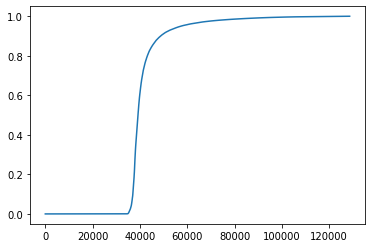

In [130]:
df_av = df_final[['ID', 'is_train']].copy()
df_av['preds'] = eval_preds
df_av_train = df_av[df_av.is_train == 1]
df_av_train = df_av_train.sort_values(by=['preds']).reset_index(drop=True)

# Check distribution
df_av_train.preds.plot()


In [131]:
# final_test = df_av_train[df_av_train['preds'] < 0.1]

In [132]:
final_test['preds']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
32572    0.0
32573    0.0
32574    0.0
32575    0.0
32576    0.0
Name: preds, Length: 32577, dtype: float64

In [133]:
train_imp

,Feature,importances_0,importances_1,importances_2,importances_3,importances_4
0,Frequency,0.0014,0.0016,0.0026,0.0006,0.0000
1,InstlmentMode,0.0000,0.0006,0.0000,0.0000,0.0006
2,LoanStatus,-0.0004,0.0004,0.0006,0.0000,0.0016
3,Area,0.0424,0.0508,0.0464,0.0442,0.0480
4,Tenure,0.0010,0.0004,0.0008,0.0010,0.0014
...,...,...,...,...,...,...
56,PaymentMode_Escrow,0.0000,0.0000,0.0000,0.0000,0.0000
57,PaymentMode_PDC,0.0002,0.0004,0.0000,-0.0006,0.0008
58,PaymentMode_PDC Reject,0.0000,0.0000,0.0000,0.0000,0.0000
59,PaymentMode_PDC_E,0.0006,0.0000,0.0000,0.0012,-0.0004


In [134]:
train_imp['Final_importance'] = train_imp['importances_0'] + train_imp['importances_1'] + train_imp['importances_2'] +train_imp['importances_3'] + train_imp['importances_4'] 
final_preds_imp['Final_importance'] = final_preds_imp['importances0'] + final_preds_imp['importances1'] + final_preds_imp['importances2'] + final_preds_imp['importances3'] + final_preds_imp['importances4'] 

In [135]:
final_preds_imp.sort_values(by='Final_importance',ascending =False)

,Feature,importances0,importances1,importances2,importances3,importances4,Final_importance
17,ManufacturerID_1049.0,0.0434,0.0342,0.0462,0.0540,0.0486,0.2264
3,Area,0.0408,0.0384,0.0448,0.0430,0.0460,0.2130
14,ZiPCODE,0.0274,0.0264,0.0300,0.0318,0.0372,0.1528
47,State_19,0.0172,0.0134,0.0066,0.0144,0.0126,0.0642
44,State_16,0.0126,0.0090,0.0108,0.0154,0.0152,0.0630
...,...,...,...,...,...,...,...
49,State_21,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0002
11,SEX,0.0000,-0.0002,0.0000,0.0000,0.0000,-0.0002
54,PaymentMode_ECS,0.0002,0.0000,0.0000,0.0000,-0.0006,-0.0004
60,PaymentMode_SI Reject,0.0000,-0.0002,-0.0002,0.0000,0.0000,-0.0004


In [136]:
avg_cv

[0.9531329550898485,
 0.9467873472387912,
 0.9510217740496163,
 0.9521612088460748,
 0.952081542111111]

In [332]:
roc_auc_score(y_score=final_preds,y_true=y_test)

ValueError: multi_class must be in ('ovo', 'ovr')

In [333]:
imp = importances(clf,X_test.drop(date_cols,axis=1),y_test)

AttributeError: 'NoneType' object has no attribute 'predict'

In [334]:
imp

,Feature,Importance
0,ManufacturerID,0.0434
1,BranchID,0.0254
2,ZiPCODE,0.0166
3,City,0.0110
4,State,0.0088
5,Area,0.0080
6,AssetID,0.0080
7,DisbursalAmount,0.0028
8,AmountFinance,0.0024
9,SupplierID,0.0022


In [335]:
imp.reset_index(inplace=True)

In [336]:
X_train = df_final[df_final['Top-up Month'].notnull()]
X_test = X_train[X_train['ID'].isin(final_test['ID'].unique())]
y_test = X_test['Top-up Month']
X_train = X_train[~X_train['ID'].isin(final_test['ID'].unique())]
y_train = X_train['Top-up Month']
X_train.drop(['Top-up Month','is_train'],axis=1,inplace=True)
X_test.drop(['Top-up Month','is_train'],axis=1,inplace=True)
df_test = df_final[df_final['Top-up Month'].isnull()]
df_test.drop(['Top-up Month','is_train'],axis=1,inplace=True)

/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [337]:
X_train.shape

(90312, 25)

In [338]:
y_test.value_counts(normalize=True)

0.0    0.808987
6.0    0.047857
5.0    0.041598
4.0    0.036069
3.0    0.034478
2.0    0.022429
1.0    0.008580
Name: Top-up Month, dtype: float64

In [339]:
y_train.value_counts(normalize=True)

0.0    0.837740
6.0    0.072316
3.0    0.024028
5.0    0.022821
4.0    0.018591
2.0    0.016698
1.0    0.007806
Name: Top-up Month, dtype: float64

In [340]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                np.unique(y_train),
                                                y_train)


/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6.], y=0        6.0
1        0.0
2        1.0
3        6.0
4        5.0
        ... 
96071    0.0
96072    0.0
96073    0.0
96074    0.0
96076    0.0
Name: Top-up Month, Length: 90312, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [341]:
X_train[['ID']]

,ID
0,1
1,2
2,3
3,7
4,8
...,...
96071,106123
96072,106124
96073,106125
96074,106126


In [342]:
class_labels = {0:0.17050222,1:18.10742556,2:8.5198191,3:5.89327118,4:7.72828185,5:6.28166067,6:1.9837301}

In [343]:
n_folds=5
folds=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=22)
avg_cv = []
final_preds = np.zeros((len(df_test), 7))
x_test_preds = np.zeros((len(X_test),7))
oof = np.zeros(len(X_train))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train.drop(date_cols,axis=1).iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train.drop(date_cols,axis=1).iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(random_state=22,n_jobs=-1,n_estimators=5000,metric='custom',class_weight='balanced')
#         clf = XGBClassifier(random_state=22,n_jobs=-1,n_estimators=2000,class_weight='balanced')
        clf.fit(X_trn, y_trn,eval_metric=evaluate_macroF1_lgb,eval_set=[(X_val,y_val)],verbose=False,early_stopping_rounds=100)
        avg_cv.append(f1_score(y_pred=clf.predict(X_val),y_true=y_val,average='macro'))
        final_preds += clf.predict_proba(df_test.drop(date_cols,axis=1))
        x_test_preds +=clf.predict_proba(X_test.drop(date_cols,axis=1))

final_preds = final_preds/n_folds
x_test_preds = x_test_preds/n_folds
print(sum(avg_cv)/n_folds)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
0.2917873572430712


In [344]:
f1_score(y_pred=[np.argmax(x) for x in x_test_preds],y_true=y_test,average='macro')

0.2973130230642453

In [345]:
importances(clf,X_test.drop(date_cols,axis=1),y_test)

,Importance
Feature,
MonthlyIncome,0.0230
ZiPCODE,0.0186
State,0.0048
AGE,0.0014
SEX,0.0008
City,0.0002
InstlmentMode,0.0000
Area,-0.0014
AssetID,-0.0026


In [346]:
final_preds

array([[6.25636682e-01, 1.15863961e-05, 2.08414157e-04, ...,
        1.94213253e-03, 9.17657916e-03, 3.59098618e-01],
       [6.87101232e-01, 3.57385677e-04, 1.88920442e-03, ...,
        8.35300442e-03, 1.54732950e-02, 2.83158861e-01],
       [4.77772583e-01, 4.22548410e-04, 4.15468390e-03, ...,
        8.97420180e-02, 8.20673155e-02, 3.38149707e-01],
       ...,
       [9.73209324e-01, 7.52872790e-09, 2.16512341e-03, ...,
        1.45147591e-05, 9.58860039e-06, 2.45983798e-02],
       [9.96574887e-01, 2.73171138e-08, 2.18746457e-04, ...,
        3.09872101e-06, 1.08453040e-06, 3.19134142e-03],
       [9.96574887e-01, 2.73171138e-08, 2.18746457e-04, ...,
        3.09872101e-06, 1.08453040e-06, 3.19134142e-03]])

In [347]:
df_test['Top-up Month'] = [np.argmax(x) for x in final_preds]

<ipython-input-347-96bbe1118d19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Top-up Month'] = [np.argmax(x) for x in final_preds]


In [348]:
df_test['Top-up Month'].value_counts(normalize=True)

0    0.673381
6    0.153611
5    0.065649
3    0.044625
4    0.042794
2    0.018447
1    0.001492
Name: Top-up Month, dtype: float64

In [349]:
from collections import Counter

In [350]:
x_test_preds.shape[0]

38343

In [351]:
y_pred=[np.argmax(x) for x in x_test_preds]
Counter(y_pred)[0]/x_test_preds.shape[0]

0.6776725869128655

In [352]:
y_test.value_counts(normalize=True)

0.0    0.808987
6.0    0.047857
5.0    0.041598
4.0    0.036069
3.0    0.034478
2.0    0.022429
1.0    0.008580
Name: Top-up Month, dtype: float64

In [353]:
y_train.value_counts(normalize=True)

0.0    0.837740
6.0    0.072316
3.0    0.024028
5.0    0.022821
4.0    0.018591
2.0    0.016698
1.0    0.007806
Name: Top-up Month, dtype: float64

In [354]:
top_up_dict_rev = {0:'No Top-up Service',
 6:' > 48 Months',
 5:'36-48 Months',
 3:'24-30 Months',
 4:'30-36 Months',
 2:'18-24 Months',
 1:'12-18 Months'}

In [355]:
df_test['Top-up Month'] = df_test['Top-up Month'].map(top_up_dict_rev)

<ipython-input-355-20c6c8975129>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Top-up Month'] = df_test['Top-up Month'].map(top_up_dict_rev)


In [356]:
df_test['Top-up Month'].value_counts(normalize=True)

No Top-up Service    0.673381
 > 48 Months         0.153611
36-48 Months         0.065649
24-30 Months         0.044625
30-36 Months         0.042794
18-24 Months         0.018447
12-18 Months         0.001492
Name: Top-up Month, dtype: float64

In [357]:
df_sub = pd.read_csv('sample_submission.csv')

In [358]:
df_sub.drop(['Top-up Month'],axis=1,inplace=True)
df_sub = pd.merge(df_sub,df_test[['ID','Top-up Month']],on='ID')

In [359]:
df_sub.to_csv('roc_adv_0.71_0.22cv_.csv',index=False)

In [360]:
df_test

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,4,2,1,0,9,2,35,46,480000,365000.0,365000.0,1000.0,2011-12-29,2015-10-05,2011-12-29,3524747,1046.0,22354,75.83,1,50.0,32069.00,186,12,473001.0,No Top-up Service
1,5,2,1,0,7,2,35,45,480000,285000.0,285000.0,9300.0,2012-04-28,2016-01-01,2012-04-28,4985862,1046.0,22354,57.44,1,35.0,25000.00,186,12,473001.0,No Top-up Service
2,6,3,0,0,7,2,35,48,580000,400000.0,400000.0,35800.0,2013-10-22,2017-09-10,2013-10-22,12881783,1060.0,65929,68.97,1,37.0,23333.33,186,12,473001.0,No Top-up Service
3,25,4,0,0,1,154,76,36,725000,500000.0,500000.0,52000.0,2013-05-21,2016-02-10,2013-05-21,10613776,1049.0,68597,61.79,1,55.0,91666.67,299,4,493558.0,No Top-up Service
4,119,3,0,0,7,194,26,48,617000,400000.0,400000.0,35400.0,2012-11-30,2016-12-05,2012-11-30,7911110,1049.0,38493,59.09,1,48.0,12500.00,214,14,754137.0,No Top-up Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14740,143396,2,0,0,7,143,74,35,530016,419616.0,419616.0,14723.0,2012-02-29,2015-02-10,2012-02-29,4276747,1046.0,22094,79.17,2,NaN,NaN,189,8,122001.0,No Top-up Service
14741,143397,2,0,0,7,32,10,36,595000,446500.0,446500.0,15491.0,2012-04-10,2015-04-05,2012-04-10,4746586,2721.0,61196,75.04,2,NaN,NaN,48,11,560020.0,No Top-up Service
14742,143398,2,0,0,7,32,10,36,595000,446500.0,446500.0,15491.0,2012-04-10,2015-04-05,2012-04-10,4746588,2721.0,61196,75.04,2,NaN,NaN,48,11,560020.0,No Top-up Service
14743,143399,2,0,0,9,246,19,12,400000,280000.0,280000.0,25350.0,2013-07-25,2014-08-10,2013-07-26,11719081,1046.0,63565,70.00,1,NaN,NaN,170,16,335001.0,No Top-up Service


In [361]:
df_sub

,ID,Top-up Month
0,4,No Top-up Service
1,5,No Top-up Service
2,6,No Top-up Service
3,25,No Top-up Service
4,119,No Top-up Service
...,...,...
14740,143396,No Top-up Service
14741,143397,No Top-up Service
14742,143398,No Top-up Service
14743,143399,No Top-up Service


In [362]:
df_test

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,4,2,1,0,9,2,35,46,480000,365000.0,365000.0,1000.0,2011-12-29,2015-10-05,2011-12-29,3524747,1046.0,22354,75.83,1,50.0,32069.00,186,12,473001.0,No Top-up Service
1,5,2,1,0,7,2,35,45,480000,285000.0,285000.0,9300.0,2012-04-28,2016-01-01,2012-04-28,4985862,1046.0,22354,57.44,1,35.0,25000.00,186,12,473001.0,No Top-up Service
2,6,3,0,0,7,2,35,48,580000,400000.0,400000.0,35800.0,2013-10-22,2017-09-10,2013-10-22,12881783,1060.0,65929,68.97,1,37.0,23333.33,186,12,473001.0,No Top-up Service
3,25,4,0,0,1,154,76,36,725000,500000.0,500000.0,52000.0,2013-05-21,2016-02-10,2013-05-21,10613776,1049.0,68597,61.79,1,55.0,91666.67,299,4,493558.0,No Top-up Service
4,119,3,0,0,7,194,26,48,617000,400000.0,400000.0,35400.0,2012-11-30,2016-12-05,2012-11-30,7911110,1049.0,38493,59.09,1,48.0,12500.00,214,14,754137.0,No Top-up Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14740,143396,2,0,0,7,143,74,35,530016,419616.0,419616.0,14723.0,2012-02-29,2015-02-10,2012-02-29,4276747,1046.0,22094,79.17,2,NaN,NaN,189,8,122001.0,No Top-up Service
14741,143397,2,0,0,7,32,10,36,595000,446500.0,446500.0,15491.0,2012-04-10,2015-04-05,2012-04-10,4746586,2721.0,61196,75.04,2,NaN,NaN,48,11,560020.0,No Top-up Service
14742,143398,2,0,0,7,32,10,36,595000,446500.0,446500.0,15491.0,2012-04-10,2015-04-05,2012-04-10,4746588,2721.0,61196,75.04,2,NaN,NaN,48,11,560020.0,No Top-up Service
14743,143399,2,0,0,9,246,19,12,400000,280000.0,280000.0,25350.0,2013-07-25,2014-08-10,2013-07-26,11719081,1046.0,63565,70.00,1,NaN,NaN,170,16,335001.0,No Top-up Service
